This example will show how to generate the trajectory analysis from [1] using the MindScoPy package

In [1]:
import mindscopy as ms
from preprocessing.artifact_removal import peak_rejection, riemannian_potato_rejection
from preprocessing.misc import epoch
from preprocessing.rebias import apply_rebias_to_groups
from preprocessing.feature_extraction import ScaledTangentSpace
import numpy as np
import mne
import pyriemann


In [2]:
# use sample data from study for now, will change this to BCI competition data later
import pickle
with open('B:/nicolas-ivanov_eeg-bci-metric-assesst_0545_data_prism/Processed Data/2-7s-preprocessed-epoched-bandpass-main.pickle', 'rb') as f:
    d = pickle.load(f)


Perform the preprocessing steps of artifact rejecting and sub-epoching.

In [3]:
data = d[2]
print(data.keys())
Xall = data['trials']
y = data['labels']
blocks = data['run_label']
print(Xall.shape)

dict_keys(['baseline', 'trials', 'raw_trials', 'labels', 'run_label'])
(360, 32, 1750)


In [4]:
# discard rest trials
Xall = Xall[y != 0]
blocks = blocks[y != 0]
y = y[y != 0]

# select channels
ch_map = {
    'FCz' : 0,
    'Fz' : 1,
    'FC3': 4,
    'C5': 6,
    'C3': 7,
    'C1': 8,
    'Cz': 9,
    'CP3': 10,
    'CPz': 11,
    'P7': 12,
    'P5': 13,
    'P3': 14,
    'P1': 15,
    'Pz': 16,
    'PO3': 17,
    'Oz': 18,
    'PO4': 19,
    'P8': 20,
    'P6': 21,
    'P4' : 22,
    'P2' : 23,
    'CP4': 24,
    'C6' : 26,
    'C4' : 27,
    'C2' : 28,
    'FC4' : 29,
}

sel_chs = np.asarray([ch_map[ch] for ch in ch_map])
X = Xall[:, sel_chs, :]

In [5]:
print(X.shape)

(180, 26, 1750)


In [6]:
# apply peak rejection
X, rejected_trials = peak_rejection(X, threshold=350, verbose=True)
y = np.delete(y, rejected_trials)
blocks = np.delete(blocks, rejected_trials)

14 trials rejected.


In [7]:
# apply riemannian potato rejection to each block of trials
clean_X = []
clean_y = []
clean_blocks = []
for block in np.unique(blocks):
    block_idx = blocks == block
    X_block = X[block_idx]
    y_block = y[block_idx]
    blocks_block = blocks[block_idx]

    X_block, rejected_trials = riemannian_potato_rejection(X_block, threshold=2.5, verbose=True)
    y_block = np.delete(y_block, rejected_trials)
    blocks_block = np.delete(blocks_block, rejected_trials)

    clean_X.append(X_block)
    clean_y.append(y_block)
    clean_blocks.append(blocks_block)

X = np.concatenate(clean_X)
y = np.concatenate(clean_y)
blocks = np.concatenate(clean_blocks)

Iteration 0: 1 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 1 total trials rejected.
Iteration 0: 0 trials rejected.
Process complete, 0 total trials rejected.
Iteration 0: 1 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 1 total trials rejected.
Iteration 0: 2 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 2 total trials rejected.


Now compute the mean covariance matrix for each block. These will be used for rebiasing the sub-epoch covariance matrices.

In [8]:
Nt, Nc, Ns = X.shape
Nblks = len(np.unique(blocks))

# block means
block_means = np.zeros((Nblks, Nc, Nc))
for i, block in enumerate(np.sort(np.unique(blocks))):
    block_covs = pyriemann.utils.covariance.covariances(X[blocks == block])
    block_means[i] = pyriemann.utils.mean.mean_covariance(block_covs)

In [9]:
# Generate sub-epochs for each trial
Fs = 250
length = 2
stride_cluster = 1
stride_traj = 0.5
Ns_epoch = int(Fs * length)
Xcluster = epoch(X, Ns_epoch, int(Fs * stride_cluster))
Xtraj = epoch(X, Ns_epoch, int(Fs * stride_traj))

In [10]:
Nclust_epochs = Xcluster.shape[1]
Ntraj_epochs = Xtraj.shape[1]

In [11]:
# apply the rebiasing to the sub-epochs
blocks_clust_epochs = np.repeat(blocks, Xcluster.shape[1])
blocks_traj_epochs = np.repeat(blocks, Xtraj.shape[1])

Xcluster = np.reshape(Xcluster, (-1, Nc, Ns_epoch))
Xtraj = np.reshape(Xtraj, (-1, Nc, Ns_epoch))

Xclust_covs = pyriemann.utils.covariance.covariances(Xcluster)
Xtraj_covs = pyriemann.utils.covariance.covariances(Xtraj)


Xclust_covs = apply_rebias_to_groups(Xclust_covs, blocks_clust_epochs, block_means)
Xtraj_covs = apply_rebias_to_groups(Xtraj_covs, blocks_traj_epochs, block_means)

In [12]:
# apply feature extraction
feature_extractor = ScaledTangentSpace().fit(Xclust_covs)
Xclust_features = feature_extractor.transform(Xclust_covs)
Xtraj_features = feature_extractor.transform(Xtraj_covs)

In [13]:
# put the data back into trial, epoch, format
Xclust_features = np.reshape(Xclust_features, (Nt, Nclust_epochs, -1))
Xtraj_features = np.reshape(Xtraj_features, (Nt, Ntraj_epochs, -1))

print(Xclust_features.shape)
print(Xtraj_features.shape)

(162, 6, 351)
(162, 11, 351)


In [14]:
# Perform clustering and generate the trajectory sub-space
np.random.seed(42)
subspace = ms.Trajectory_Subspace(krange=range(2,8)).fit(Xclust_features, verbose=True)

Selecting the number of clusters using prediction strength.
Number of clusters selected: 5
Singular values: [5.87117073e+00 4.56294777e+00 4.27106373e+00 3.11766809e+00
 1.16494045e-15]
w shape: (351, 5), U shape: (351, 5)


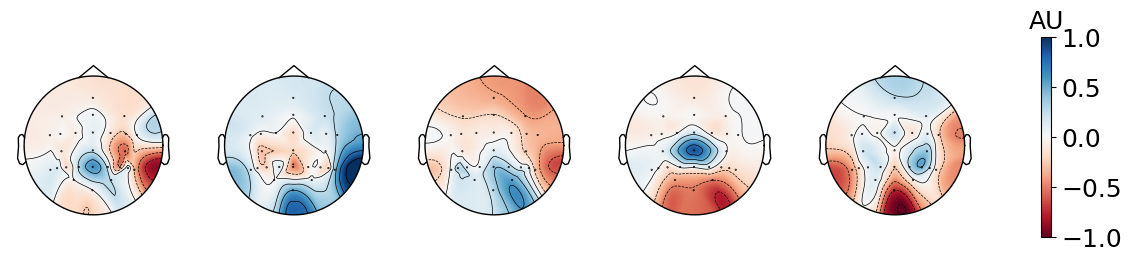

In [15]:
# visulize the pattern state activation patterns
subspace.plot_state_activation_patterns(np.reshape(Xclust_features, (-1, Xclust_features.shape[-1])), Xclust_covs, list(ch_map.keys()))

In [16]:
print(subspace.clustering_model.cluster_centers_.shape)

(5, 351)


In [17]:
# select a block and task to analyze
block = 1
task = 3

X_blk = Xtraj_features[blocks == block]
y_blk = y[blocks == block]

X_task = X_blk[y_blk == task]

In [18]:
Traj_all_tasks = ms.Trajectory(subspace)
Traj_all_tasks.fit(X_blk)

Traj_task = ms.Trajectory(subspace)
Traj_task.fit(X_task)

In [19]:
# compute the InterTaskDiff
InterTaskDiff = Traj_task.InterTaskDiff(Traj_all_tasks)
print(np.log(InterTaskDiff))

[-3.0993677  -3.0280334  -2.6226777  -2.37844368 -2.19320198 -2.37660475
 -2.35760132 -2.65314097 -3.1941804  -2.77340902 -2.49289199]


In [20]:
# Computer InterTrialVar
InterTrialVar = Traj_task.InterTrialVar(Traj_all_tasks)
print(InterTrialVar)

[0.82874288 0.8223489  0.79290105 0.79444242 0.81856226 0.861941
 0.73530872 0.77539646 0.86556002 0.75896812 0.64534807]


In [21]:
# Compute IntraTrialVar
IntraTrialVar = Traj_task.IntraTrialVar()
print(IntraTrialVar)

0.1439939834379804


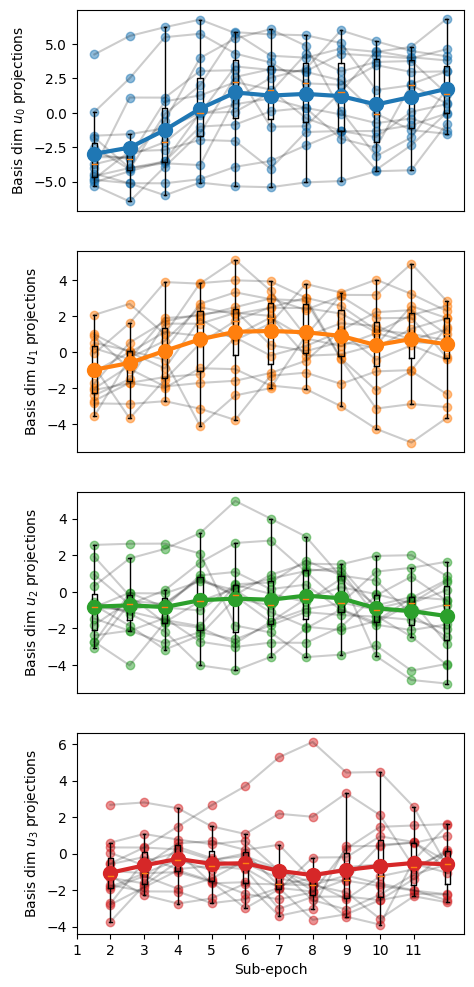

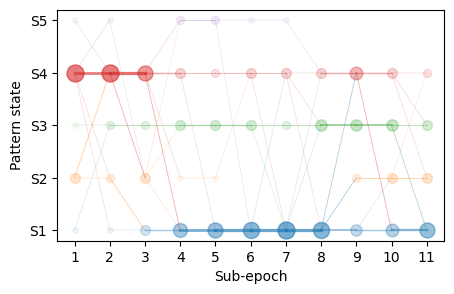

In [22]:
# visualize the trajectory
Traj_task.plot()